# Deep learning para Series Temporales

* Haremos una **predicción de temperaturas** de **24 horas en el futuro**, dada una **serie temporal** de **medidas de cantidades** (cada hora) coeespondientes a **presión** y **humedad** recogidas en el **pasado reciente** por un conjunto de sensores en lo alto de un edificio.
* Veremos que, **modelos** con **capas densas** o **redes convolucionales no** son **adecuadas** para este **tipo** de set de **datos** mientras que una técnica diferente de machine learning (Redes Neuronales Recurrentes **RNNs**), son **ideales** para este tipo de problemas.
El dataset se ha obtenido de la estación meteorilógica del Max Plank Institure for Biogeochemistry en Jena, Alemania. [http://www.bgc-jena.mpg.de/wetter](http://www.bgc-jena.mpg.de/wetter)

## Un ejemplo de pronóstico de temperatura

El dataset se compone de 14 magnitudes, como temperatura, presión, humedad, dirección del viento, etc. grabadas cada 10' durante varios años (2009-2016). Descargamos y descomprimimos el dataset

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-06 08:19:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.232.16, 52.216.10.133, 52.216.128.5, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.232.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  40.1MB/s    in 0.3s    

2023-02-06 08:19:27 (40.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Echamos un vistazo al dataset**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Esto devuelve una cuenta de 420.451 líneas de datos (cada línea es un timestep: un registro de una fecha con 14 valores relativos a las condiciones meteorológicas)

**Parseamos los datos**

Ahora, **convertimos** las 420.551 **líneas de datos** en **arrays NumPy**: **un array para** la **temperatura** (en Celsius), y **otro para el resto de los datos**-las características que usaremos para predecir futuras temperaturas. Notar que **hemos descartado** la columna **"Date Time"**

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    # Guardamos columna 1 en el array temperatura
    temperature[i] = values[1]
    # Guardamos todas las columnas (temperatura  
    # incluida) en el array raw_data 
    raw_data[i, :] = values[:]

**Pintamos la serie temporal de temperaturas**

Podemos ver claramente la **periodicidad anual de la temperatura**. Los datos se extienden durante 8 años

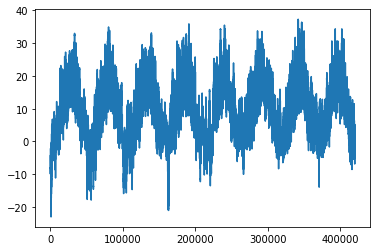

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Pintamos los 10 primeros días de la serie temporal de temperaturas**

Como los datos están registrados cada 10', obtenemos 24 x 6 = 144 puntos de datos al dia

Así vemos la periodicidad diaria , especialmente de los últimos 4 días. Notad también que este periodo de 10 días debe venir de un mes de invierno bastante fío.

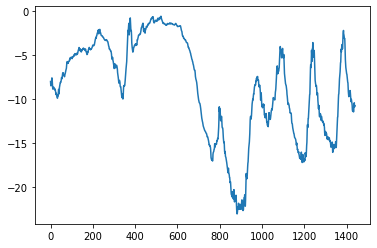

In [6]:
plt.plot(range(1440), temperature[:1440])

**BUSCAD SIEMPRE LA PERIODICIDAD EN VUESTROS DATOS**

La **periodicidad en múltiples escalas de tiempo** es una **propiedad importante** y muy común de los **datos de series temporales**. Ya sea que esté mirando el clima, la ocupación del estacionamiento del centro comercial, el tráfico a un sitio web, las ventas de una tienda de comestibles o los pasos registrados en un rastreador de actividad física, verá **ciclos diarios** y **ciclos anuales** (los datos generados por humanos también tienden a presentar ciclos semanales). **Al explorar** los **datos**, aseguraos de **buscar estos patrones**.

Con nuestro conjunto de datos, **si estuviera tratando de predecir la temperatura promedio** para el **próximo mes dados algunos meses de datos anteriores**, el **problema** sería **fácil**, debido a la **periodicidad confiable de la escala anual de los datos**. Pero **al observar los datos en una escala de días, la temperatura parece mucho más caótica**. **¿Es esta serie temporal predecible a escala diaria?** Vamos a ver.

**En todos nuestros experimentos**, **usaremos el primer 50% de los datos para entrenamiento**, el **siguiente 25% para validación** y el **último 25% para pruebas**. Cuando se **trabaja** con datos de **series temporales**, es **importante usar datos de validación y prueba que sean más recientes que los datos de entrenamiento**, **porque está tratando de predecir el futuro dado el pasado**, no al revés, y **las divisiones de validación/prueba deben reflejar eso**. ¡Algunos problemas resultan considerablemente más simples si inviertes el eje del tiempo!

**Computamos el número de muestras que usaremos para cada lote de datos**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparación de los datos

La **formulación** exacta **del problema** será la siguiente: **dados los datos que cubren los cinco días anteriores y muestreados una vez por hora, ¿podemos predecir la temperatura en 24 horas?**

**Primero**, **preprocesamos los datos en un formato que una red neuronal pueda ingerir**. Esto es **fácil**: los **datos ya son numéricos**, por lo que no es necesario realizar ninguna vectorización. Pero **cada serie de tiempo en los datos está en una escala diferente** (por ejemplo, la presión atmosférica, medida en mbar, es de alrededor de 1000, mientras que el H2OC, medido en milimoles por mol, es de alrededor de 3). **Normalizaremos cada serie temporal de forma independiente para que todas tomen valores pequeños** en una **escala similar**. **Vamos a usar los primeros 210.225 pasos de tiempo como datos de entrenamiento**, por lo que **calcularemos la media y la desviación estándar solo en esta fracción de los datos**.

**Normalizando los datos**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

A continuación, **creamos un objeto ``Dataset``** que **produzca lotes** de datos de los **últimos cinco días** **junto con** una **temperatura objetivo** **dentro de las 24 horas siguientes**. Debido a que las **muestras** en el conjunto de datos son **altamente redundantes** (la muestra ``N`` y la muestra ``N + 1`` tendrán la mayoría de sus intervalos de tiempo en común), sería un desperdicio asignar memoria explícitamente para cada muestra. En su lugar, **generaremos las muestras sobre la marcha** y solo mantendremos en la memoria los arrays ``raw_data`` y de ``temperature`` originales, y nada más.

Podríamos escribir fácilmente un generador de Python para hacer esto, pero hay una utilidad incorporada en Keras que hace exactamente eso (**``timeseries_dataset_from_array()``**), por lo que podemos ahorrarnos algo de trabajo al usarlo. Por lo general, se puede usar para cualquier tipo de tarea de pronóstico de series temporales.

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**COMPRENDIENDO ``TIMESERIES_DATASER_FROM_ARRAY()``**

Para comprender qué hace ``timeseries_dataset_from_array()``, veamos un ejemplo simple. La idea general es que proporcionemos una matriz de datos de series temporales (el argumento ``data``) y ``timeseries_dataset_from_array()`` nos proporcione **ventanas extraídas de las series temporales originales** (las llamaremos **"secuencias"**).

Por ejemplo, si usamos ``data = [0 1 2 3 4 5 6]`` y ``sequence_length=3``, entonces ``timeseries_dataset_from_array()`` generará las siguientes muestras: ``[0 1 2]``, ``[1 2 3]``, ``[2 3 4]``, ``[3 4 5]``, ``[4 5 6]``.

También podemos pasar un argumento ``targets`` (un array) a ``timeseries_dataset_ from_array()``. La primera entrada del array de ``targets`` debe coincidir con el ``target`` deseado para la primera secuencia que se generará a partir del array ``data``. Entonces, si está haciendo pronósticos de series temporales, ``targets`` debe ser el mismo array que ``data``, compensados o con un offset de una cierta cantidad.

Por ejemplo, con ``data = [0 1 2 3 4 5 6 ...]`` y ``sequence_length=3``, podría crear un dataset para predecir el siguiente paso en la serie pasando ``targets = [3 4 5 6 ...]``. Vamos a intentarlo:

In [9]:
import numpy as np 
from tensorflow import keras
# Genera un array de enteros ordenados de 0 a 9
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    # Las secuenciuas que generamos serán
    # muestreadas desde [0 1 2 3 4 5 6]
    data=int_sequence[:-3],
    # El target para la secuencia que 
    # comienza en data[N] será data[N+3] 
    targets=int_sequence[3:],
    # La secuencia será de 3 pasos
    sequence_length=3,
    # La secuencia se agrupará
    # en lotes de tamaño 2
    batch_size=2,
)
 
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Usaremos ``timeseries_dataset_from_array()`` para instanciar tres datasets: uno para **entrenamiento**, otro para **validación** y otro para **prueba**.

Usaremos los siguientes valores de parámetro:

* ``sampling_rate = 6``: las observaciones se muestrearán en un punto de datos por hora: solo mantendremos un punto de datos de 6.
* ``sequence_length = 120``: las observaciones retrocederán 5 días (120 horas).
* ``delay = sampling_rate * (sequence_length + 24 - 1)``: el target de una secuencia será la temperatura 24 horas después del final de la secuencia.

Al crear el conjunto de datos de **entrenamiento**, pasaremos ``start_index = 0`` y ``end_index = num_train_samples`` para **usar solo el primer 50% de los datos**. Para el dataset de **validación**, pasaremos ``start_index = num_train_samples`` y ``end_index = num_train_samples + num_val_samples`` para **usar el siguiente 25% de los datos**. Finalmente, para el dataset de **prueba**, pasaremos ``start_index = num_train_samples + num_val_samples`` para **usar las muestras restantes**.

**Instanciando datasets para entrenamiento, validación y testing**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Cada dataset produce una tupla (**``samples``**, **``targets``**) (muestras, objetivos), donde ``samples`` es un lote de 256 muestras, **cada una de las cuales** contiene **120 horas consecutivas** de datos de entrada, y ``targets`` es el array correspondiente de 256 temperaturas objetivo. Daos cuenta que las **muestras se mezclan aleatoriamente** (randomly shuffled), por lo que dos secuencias consecutivas en un lote (como ``samples[0]`` y ``samples[1]``) no son necesariamente temporalmente cercanas.

**Inspeccionando la salida de uno de nuestros datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Comenzando con un modelo de referencia con sentido común sin usar machine-learning

Antes de comenzar a usar modelos de aprendizaje profundo de caja negra para resolver el problema de la predicción de la temperatura, **probemos un enfoque simple y de sentido común**. Servirá como una verificación necesaria y establecerá una **línea de base** que **tendremos que superar** para **demostrar** la **utilidad** de los **modelos de aprendizaje automático más avanzados**. Estas **líneas de base de sentido común** pueden ser **útiles** cuando **nos enfrentamos a un nuevo problema** para el que no existe una solución conocida (todavía). Un ejemplo clásico es el de las **tareas de clasificación desequilibradas**, donde algunas clases son mucho más comunes que otras. (Si su conjunto de datos contiene un 90% de instancias de clase A y un 10 % de instancias de clase B, entonces un enfoque de sentido común para la tarea de clasificación es predecir siempre "A" cuando se le presente una nueva muestra. Dicho clasificador tiene una precisión del 90% en general y, por lo tanto, cualquier enfoque basado en el aprendizaje debería superar este puntaje del 90% para demostrar su utilidad). **A veces, estas líneas de base elementales pueden resultar sorprendentemente difíciles de superar**.

En este caso, **se puede suponer con cierta seguridad que las series de tiempo de temperatura son continuas** (es **probable que las temperaturas de mañana estén cerca de las temperaturas de hoy)**, así como **también periódicas con un período diario**. Por lo tanto, **un enfoque de sentido común es predecir siempre que la temperatura dentro de 24 horas será igual a la temperatura en este momento**. Evaluemos este enfoque, utilizando la **métrica del error absoluto medio (MAE)**, definida de la siguiente manera:

**``np.mean(np.abs(preds - targets))``**

**Computando un modelo de referencia con MAE, usando sentido común**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # La característica 'temperatura' está en la columna 1, 
        # por lo que samples[:, -1, 1] es la última medición de 
        # temperatura en la secuencia de entrada. Recordad que 
        # normalizamos nuestras características, por lo que para 
        # recuperar una temperatura en grados Celsius, debemos 
        # desnormalizarla multiplicándola por la desviación 
        # estándar y sumando nuevamente la media.
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Esta línea base de sentido común logra un MAE de validación de 2,44 grados Celsius y un MAE de prueba de 2,62 grados Celsius. Entonces, si asumimos siempre que la temperatura dentro de 24 horas será la misma que ahora, nos equivocaremos en dos grados y medio en promedio. No es un resultado tan malo, pero probablemente no nos dejarán lanzar un servicio de pronóstico del tiempo basado en esta heurística. Ahora la cuestión es **usar nuestro conocimiento de aprendizaje profundo para hacerlo mejor**.

### Intentémoslo con un modelo básico de machine-learning

De la misma manera que es **útil establecer una línea de base de sentido común antes de probar enfoques de aprendizaje automático**, es **útil probar modelos de aprendizaje automático simples y económicos** (como **redes pequeñas y densamente conectadas**) **antes** de buscar **modelos complicados y computacionalmente costosos como RNN**. Esta es la mejor manera de asegurarse de que cualquier complejidad adicional que arroje al problema sea legítima y brinde beneficios reales.

El siguiente listado de código muestra un **modelo completamente conectado que comienza aplanando los datos y luego los ejecuta a través de dos capas densas**. Tener en cuenta la **falta de una función de activación en la última capa densa**, que es **típica de un problema de regresión**. Usamos el **error cuadrático medio (MSE) como la pérdida**, **en lugar de MAE**, porque **a diferencia de MAE**, es **uniforme alrededor de cero**, que es una **propiedad útil para el descenso de gradiente**. Supervisaremos MAE agregándolo como una métrica en compile().

**Entrenando y evaluando un modelo densamente conectado**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    # Utilizamos un callback para guardar el modelo de mejor rendimiento.
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Recordar que utilizamos un callback para guardar el modelo de mejor 
# rendimiento. Vuelva a cargar el mejor modelo y lo evalúa en los datos de prueba.
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 14ms/step - loss: 14.7995 - mae: 2.9403 - val_loss: 10.8195 - val_mae: 2.5833
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 9.5463 - mae: 2.4339 - val_loss: 11.2441 - val_mae: 2.6461
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 8.7288 - mae: 2.3270 - val_loss: 11.0071 - val_mae: 2.6237
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 8.2522 - mae: 2.2621 - val_loss: 10.2255 - val_mae: 2.5365
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 7.9196 - mae: 2.2158 - val_loss: 10.4929 - val_mae: 2.5660
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.6447 - mae: 2.1777 - val_loss: 11.4802 - val_mae: 2.6823
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 7.4263 - mae: 2.1457 - val_loss: 10.8963 - val_mae: 2.6225
Epoch 8/10
819/819 [==============================] - 

**Pintando los resultados**

Pintamos las **curvas de pérdida** para **validación** y **entrenamiento**

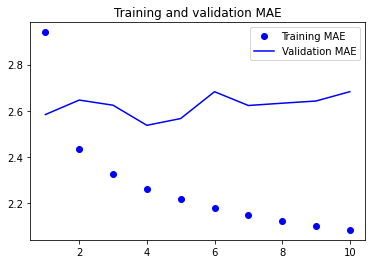

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Algunas de las **pérdidas de validación** están **cerca** de la **línea de base sin aprendizaje automático**, pero no de manera confiable. Esto demuestra lo **importante de tener esta línea de base en primer lugar**: resulta que **no es fácil de superar**. Nuestro sentido común contiene mucha información valiosa a la que un modelo de aprendizaje automático no tiene acceso.

Quizás nos preguntemos, si existe un modelo simple y con buen rendimiento para pasar de los datos a los targets (la línea base de sentido común), **¿por qué el modelo que estamos entrenando no lo encuentra y lo mejora?** Bien, el **espacio de modelos en el que estamos buscando una solución**, es decir, nuestro **espacio de hipótesis**, es el **espacio de todas las redes de dos capas posibles con la configuración que definimos**. La **heurística del sentido común es solo un modelo entre millones que se pueden representar en este espacio**. Es como **buscar una aguja en un pajar**. **El hecho de que técnicamente exista una buena solución en nuestro espacio de hipótesis no significa que podrá encontrarla a través del descenso de gradiente**.

**Esta es una limitación bastante significativa del aprendizaje automático en general: a menos que el algoritmo de aprendizaje esté codificado para buscar un tipo específico de modelo simple, a veces puede fallar al encontrar una solución simple a un problema simple**. Es por eso que es **esencial adelantar el aprovechar una buena ingeniería de características y establecer arquitectura relevantes previas: necesitamos decirle con precisión a nuestro modelo lo que debería estar buscando.**

### Intentémoslo con un modelo convolucional 1D

Hablando de aprovechar las arquitecturas previas correctas, dado que nuestras **secuencias de entrada presentan ciclos diarios**, **tal vez un modelo convolucional podría funcionar**. Una **convnet temporal podría reutilizar las mismas representaciones en diferentes días**, **al igual que una convnet espacial puede reutilizar las mismas representaciones en diferentes ubicaciones en una imagen**.

Ya conocemos las capas **``Conv2D``** y **``SeparableConv2D``**, que **ven sus entradas a través de pequeñas ventanas que se desplazan por cuadrículas 2D**. También **hay versiones 1D e incluso 3D de estas capas**: **``Conv1D``**, **``SeparableConv1D``** y **``Conv3D``**. La capa ``Conv1D`` se basa en ventanas 1D que se deslizan por las secuencias de entrada, y la capa ``Conv3D`` se basa en **ventanas cúbicas que se deslizan por los volúmenes de entrada**.

Tener en cuenta que **no hay una capa ``SeparableConv3D``**, no por ninguna razón teórica, sino simplemente porque no se ha implementado.

Por lo tanto, **podemos construir convnets 1D, estrictamente análogos a convnets 2D**. Son **ideales** para cualquier **secuencia de datos** que siga la **suposición de invariancia de traducción** (lo que significa que **si desliza una ventana sobre la secuencia, el contenido de la ventana debe seguir las mismas propiedades independientemente de la ubicación de la ventana**).

Intentemos uno en nuestro problema de pronóstico de temperatura. Elegiremos una **longitud de ventana inicial de 24, de modo que veamos 24 horas de datos a la vez (un ciclo)**. A medida que disminuimos la muestra de las secuencias (a través de las capas MaxPooling1D), reduciremos el tamaño de la ventana en consecuencia:

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 14ms/step - loss: 22.3139 - mae: 3.7224 - val_loss: 15.4026 - val_mae: 3.1049
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 15.9642 - mae: 3.1817 - val_loss: 14.4381 - val_mae: 3.0063
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 14.5195 - mae: 3.0298 - val_loss: 15.8319 - val_mae: 3.1732
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 13.5946 - mae: 2.9296 - val_loss: 15.3533 - val_mae: 3.0876
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 12.8591 - mae: 2.8474 - val_loss: 15.9926 - val_mae: 3.1510
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 12.2522 - mae: 2.7753 - val_loss: 16.7417 - val_mae: 3.2718
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 11.7652 - mae: 2.7164 - val_loss: 14.8644 - val_mae: 3.0623
Epoch 8/10
819/819 [============================

Obtenemos las **curvas de entrenamiento y validación**

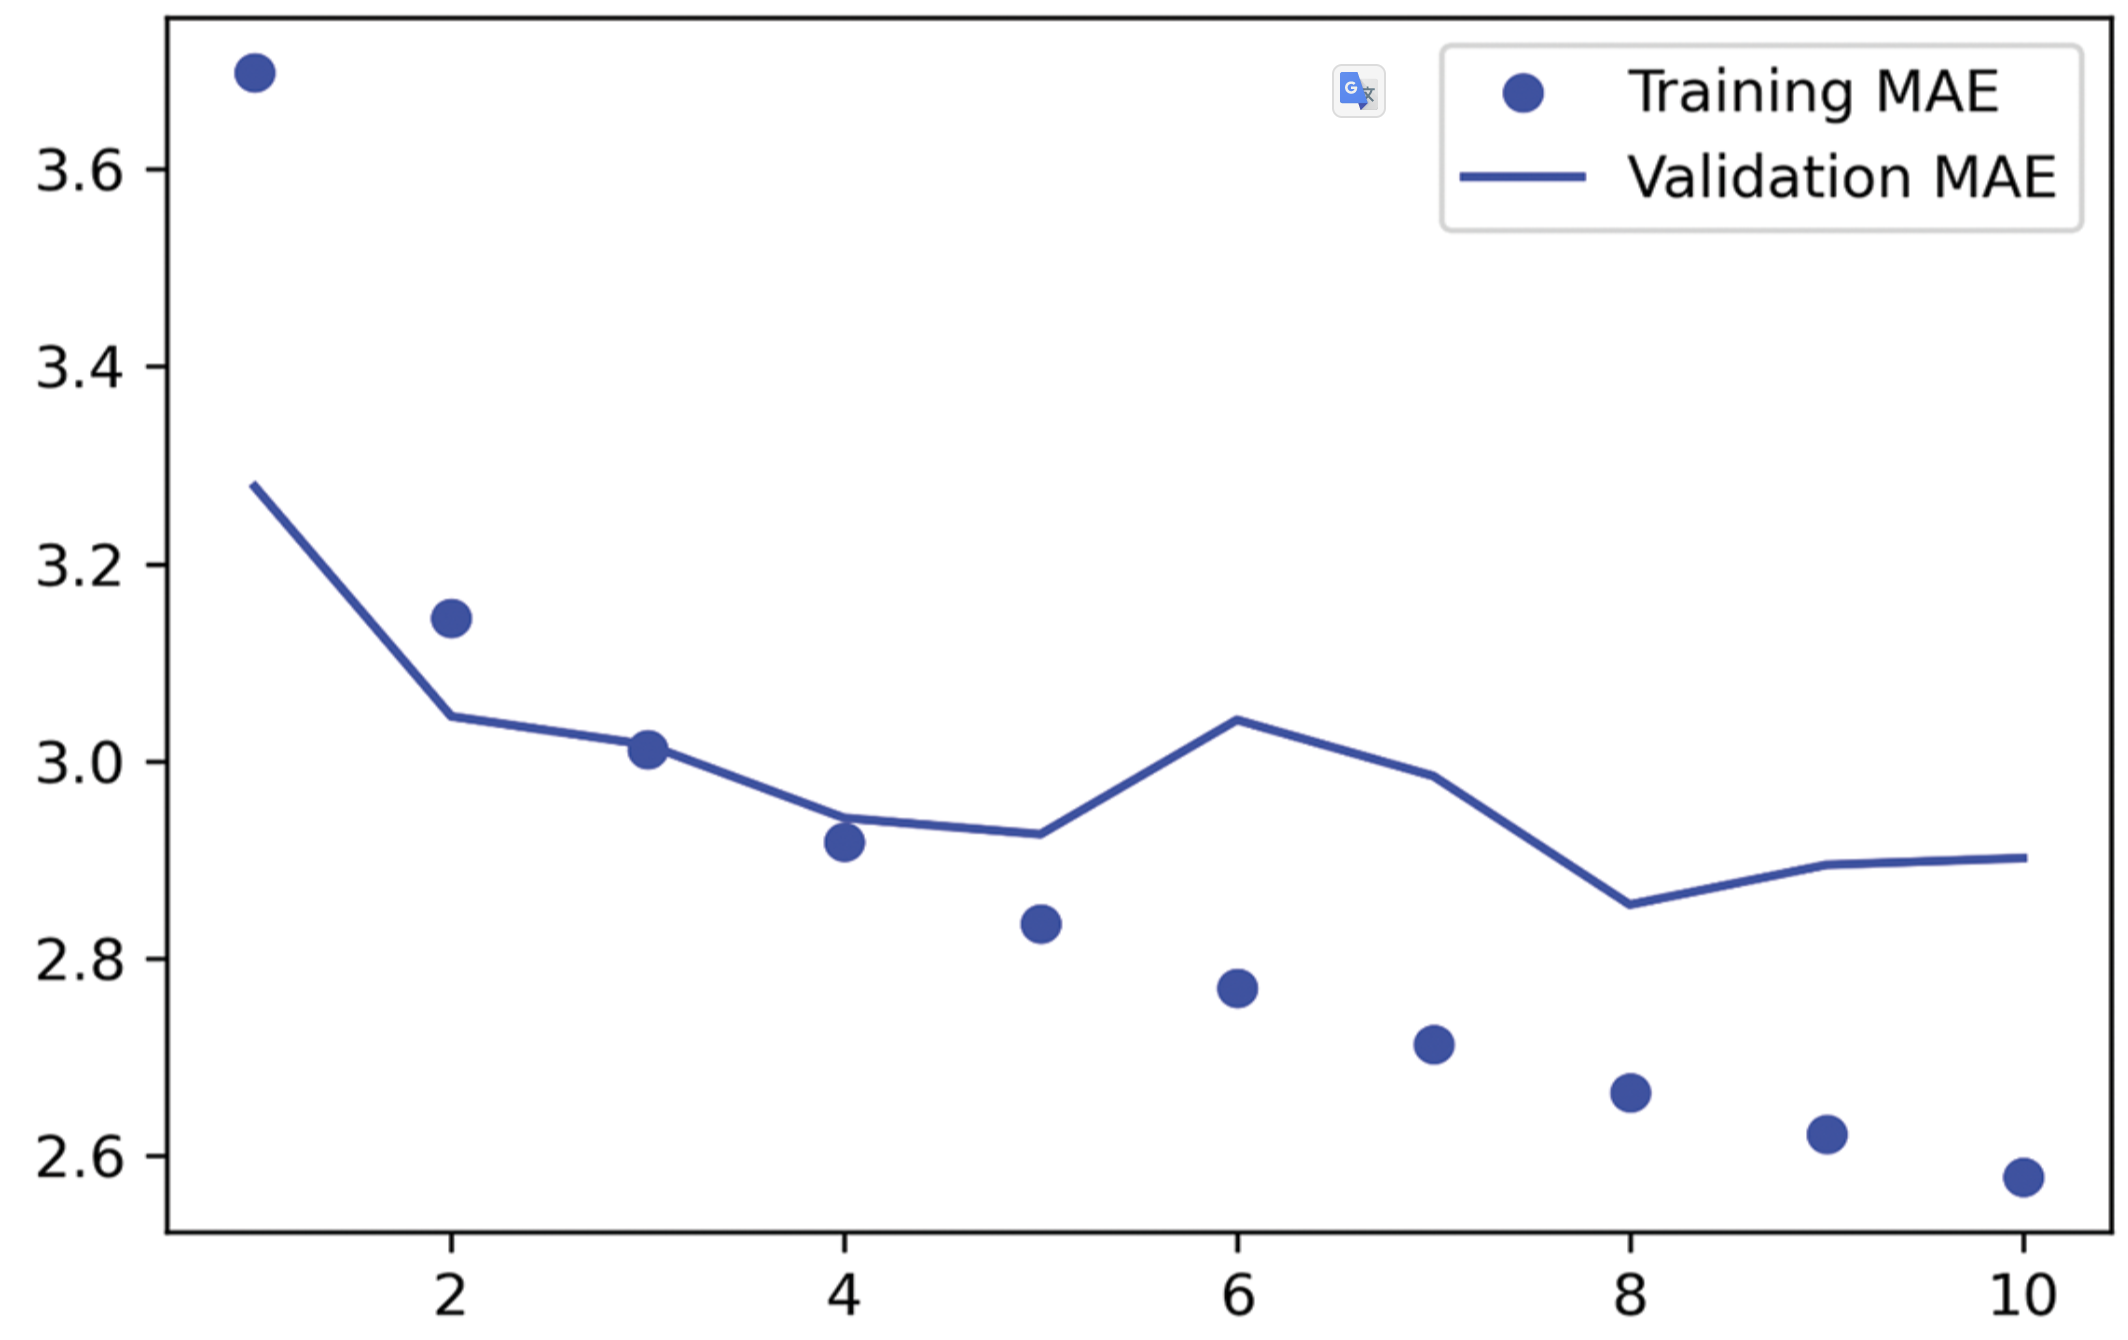

Resulta que **este modelo funciona incluso peor que el modelo densamente conectado**, y solo logra un MAE de validación de aproximadamente 2,9 grados, **muy lejos de la línea base de sentido común**. ¿Qué salió mal aquí? Dos cosas:

* En **primer lugar**, los **datos meteorológicos no respetan del todo la suposición de invariancia de traducción**. Si bien los **datos presentan ciclos diarios**, los **datos de una mañana siguen diferentes propiedades que los datos de una tarde o de la mitad de la noche**. Los **datos meteorológicos solo son invariantes a la traducción para una escala de tiempo muy específica**.
* En **segundo lugar**, **el orden en nuestros datos importa mucho**. **El pasado reciente es mucho más informativo para predecir la temperatura del día siguiente que los datos de hace cinco días**. Una **convnet 1D no puede aprovechar este hecho**. En particular, **nuestras capas de agrupación máxima y agrupación promedio global están destruyendo en gran medida esa información**.

### Un primer modelo básico recurrente

**Ni el enfoque densamente conectado ni el enfoque convolucional funcionaron bien**, pero **eso no significa que el aprendizaje automático no sea aplicable a este problema**. El **enfoque densamente conectado primero aplanó las series temporales, lo que eliminó la noción de tiempo de los datos de entrada**. El enfoque **convolucional trató todos los segmentos de los datos de la misma manera, incluso aplicando la agrupación, lo que destruyó la información del orden**. En cambio, **veamos los datos como lo que son: una secuencia, donde la causalidad y el orden son importantes**.

Hay una **familia de arquitecturas de redes neuronales diseñadas específicamente para este caso** de uso: ***redes neuronales recurrentes***. ***Entre ellos, la capa de memoria a largo-corto plazo (LSTM)*** ha sido muy popular durante mucho tiempo. Veamos cómo funcionan estos modelos, pero **comencemos probando la capa LSTM**.

**Un modelo simple basado en LSTM (Long Short Term Memory)**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 17ms/step - loss: 42.0492 - mae: 4.7215 - val_loss: 12.7331 - val_mae: 2.7184
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 10.9884 - mae: 2.5763 - val_loss: 10.3645 - val_mae: 2.4777
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.5681 - mae: 2.4163 - val_loss: 10.1571 - val_mae: 2.4532
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 9.0719 - mae: 2.3513 - val_loss: 10.0834 - val_mae: 2.4754
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 8.6229 - mae: 2.2948 - val_loss: 9.8471 - val_mae: 2.4706
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 8.3134 - mae: 2.2534 - val_loss: 9.8711 - val_mae: 2.4781
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.1058 - mae: 2.2245 - val_loss: 9.8300 - val_mae: 2.4627
Epoch 8/10
819/819 [==============================] - 14

Mostramos los resultados que son .. ¡**Mucho mejores**!. Conseguimos un MAE de validación tan bajo como 2,36 grados y un MAE de prueba de 2,55 grados. El **modelo basado en LSTM finalmente puede superar la línea base de sentido común** (aunque solo un poco, por ahora), lo que demuestra el valor del aprendizaje automático en esta tarea.

**MAE de entrenamiento y validación en la tarea de pronóstico de temperatura** de Jena **con un modelo basado en LSTM** (tened en cuenta que omitimos la época 1 en este gráfico, porque su valor es 7.75 y distorsionaría la escala)

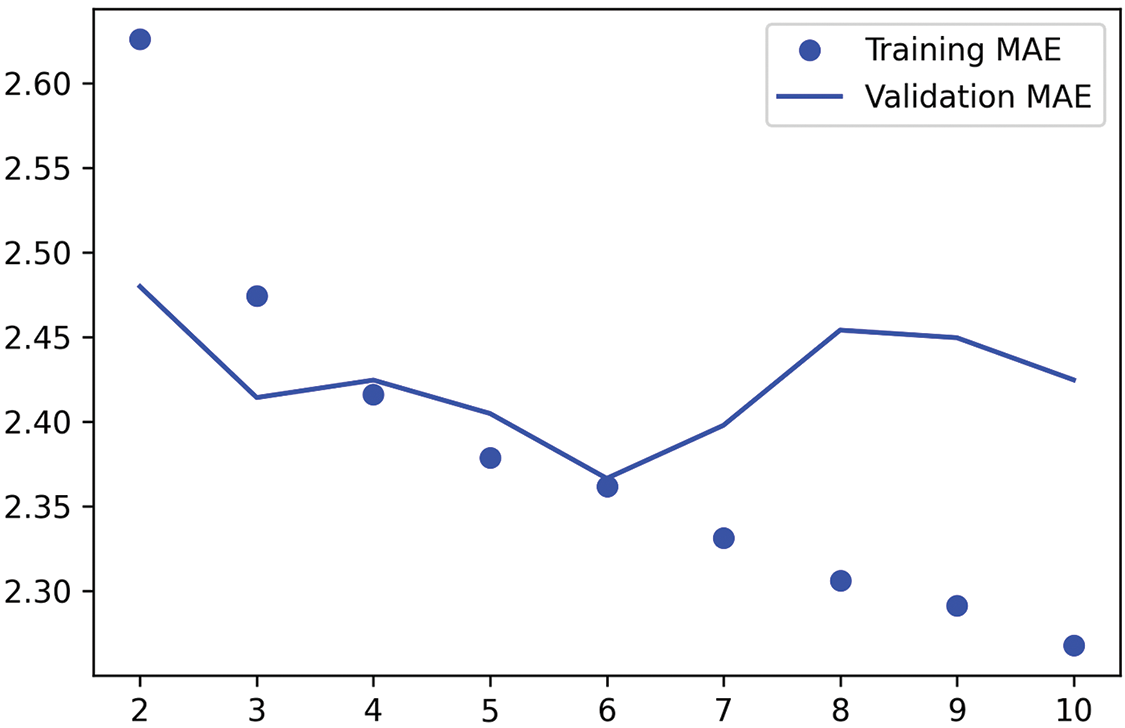

Pero, ¿por qué el modelo LSTM ha tenido un desempeñó notablemente mejor que el modelo densamente conectado o el convnet? ¿Cómo podemos refinar aún más el modelo? Para responder a esto, echemos un vistazo más de cerca a las redes neuronales recurrentes.

## Entendiendo las redes neuronales recurrentes (RNN)

Una característica importante de todas las **redes neuronales** que **hemos visto hasta ahora**, como las redes densamente conectadas y los convnets, es que **no tienen memoria**. Cada entrada que se les muestra se procesa de forma independiente, **sin que se mantenga ningún estado entre las entradas**. Con tales redes, para procesar una secuencia o una serie temporal de datos, deberíamos **mostrar la secuencia completa a la vez**: convertirla en un solo punto de datos. Por ejemplo, **esto es lo que hicimos en el ejemplo de la red densamente conectada**: **aplanamos nuestros cinco días de datos en un solo vector grande y lo procesamos de una sola vez**. Estas redes se denominan **redes feedforward**.

Por el contrario, mientras leemos la oración actual, la procesamos palabra por palabra, o más bien, vistazo a vistazo, mientras **conservamos recuerdos de lo que vino antes**; **esto da una representación fluida del significado transmitido por esta oración**. La inteligencia biológica procesa la información de manera incremental mientras mantiene un modelo interno de lo que está procesando, construido a partir de información pasada y constantemente actualizado a medida que ingresa nueva información.

**Una red neuronal recurrente (RNN) adopta el mismo principio, aunque en una versión extremadamente simplificada**: ***procesa secuencias iterando a través de los elementos de la secuencia y manteniendo un estado que contiene información relativa a lo que ha visto hasta ahora***. En efecto, una RNN es un tipo de red neuronal que tiene un bucle interno

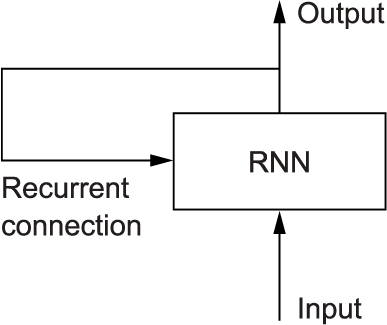

El **estado** de la RNN **se restablece entre el procesamiento de dos secuencias diferentes e independientes** (como dos muestras en un lote), por lo que aún considera que **una secuencia es un punto de datos único**: una entrada única a la red. Lo que cambia es que este **punto de datos ya no se procesa en un solo paso**; más bien, **la red realiza un bucle interno sobre elementos de secuencia**.

Para aclarar estas nociones de **bucle** y **estado**, implementemos el pase hacia adelante (forward pass) de un RNN de juguete. Este RNN **toma como entrada una secuencia de vectores**, que **codificaremos como un tensor de tamaño de rango 2** **``(timesteps, input_features)``**. **Recorre los pasos de tiempo** (timesteps) y, **en cada paso** de tiempo, **considera su estado actual en ``t`` y la entrada en ``t``** (de forma ``(input_features)``, y **los combina para obtener la salida en ``t``**. **Luego estableceremos el estado para el siguiente paso** a ser esta salida anterior. **Para el primer paso de tiempo, la salida anterior no está definida**; por lo tanto, **no hay un estado actual**. Entonces, **inicializaremos el estado como un vector de ceros llamado estado inicial de la red**.

En pseudocódigo, este es el RNN.

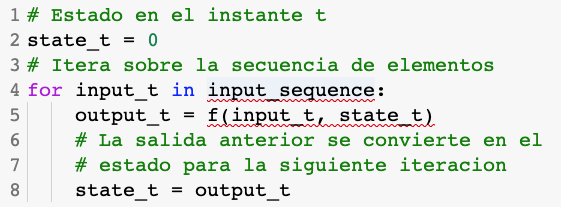

Se puede, incluso, desarrollar la función ``f``: **la transformación de la entrada y el estado en una salida estará parametrizada por dos matrices**, ``W`` y ``U``, y un **vector de bias** (o umbrales). Es similar a la transformación operada por una capa densamente conectada en una red feedforward.

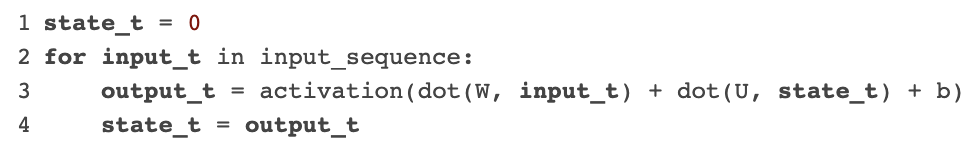

Para que estas nociones sean absolutamente inequívocas, escribamos una implementación NumPy ingenua (naive) del paso hacia adelante del RNN simple.

**Implementación de una RNN simple basado en NumPy**

In [17]:
import numpy as np
# Número de timesteps en la secuencia de entrada
timesteps = 100
# Dimensionalidad del espacio de características de entrada
input_features = 32
# Dimensionalidad del espacio de características de salida
output_features = 64
# Datos de entrada: ruido aleatorio para mejorar el ejemplo
inputs = np.random.random((timesteps, input_features))
# Estado inicial: un vector de ceros
state_t = np.zeros((output_features,))
# Creamos matrices de pesos aleatorios
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
# input_t es un vector con la forma (input_features,)
for input_t in inputs:
  # Combina la entrada con el estado actual (la salida anterior) 
  # para obtener la salida actual. Usamos tanh para agregar no 
  # linealidad (podríamos usar cualquier otra función de activación).
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  # Almacena la salida en una lista
  successive_outputs.append(output_t)
  # Actualiza el estado de la red para el próximo timestep
  state_t = output_t
# El resultado final es un tensor de 
# rango 2 con la forma (timesteps, output_features)
final_output_sequence = np.stack(successive_outputs, axis=0)

En resumen, un **RNN** es un **bucle for que reutiliza las cantidades calculadas durante la iteración anterior del bucle**, nada más. Por supuesto, **hay muchos RNN diferentes que se ajustan a esta definición** que se podrían crear; este ejemplo es una de las formulaciones de RNN más simples. **Las RNN se caracterizan por su función escalonada**, como la siguiente función en este caso:

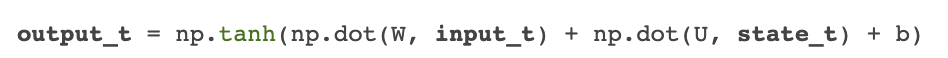

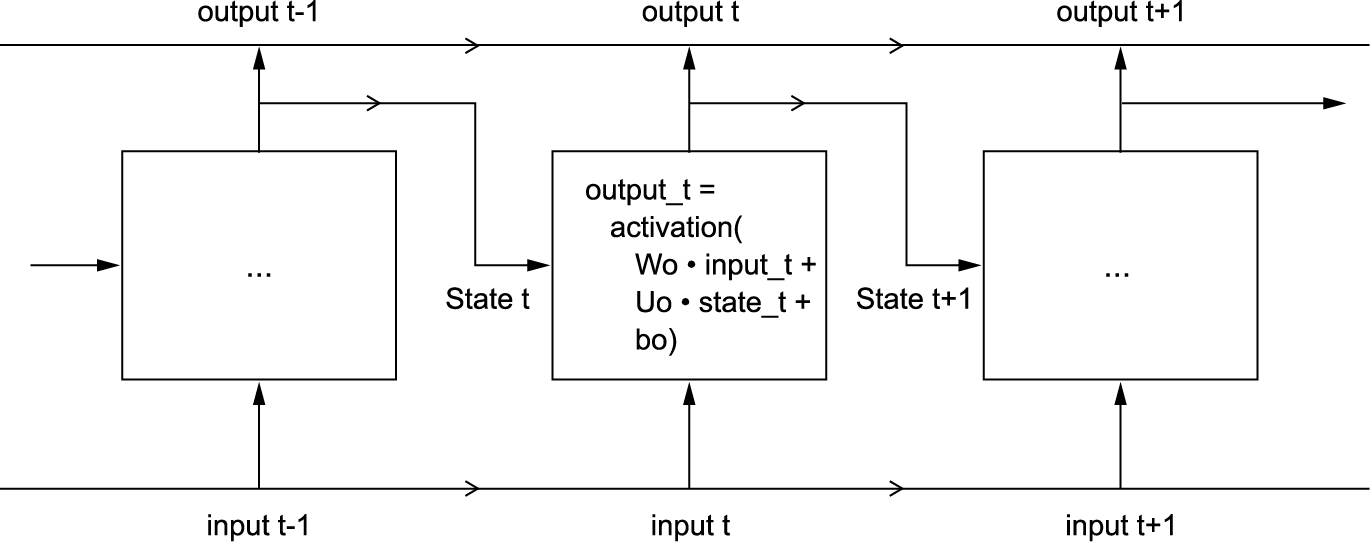

**NOTA**

En este ejemplo, la salida final es un tensor de rango 2 con la forma ``(timesteps, output_features)``, donde cada timestep es la salida del bucle en el tiempo ``t``. Cada timestep ``t`` en el tensor de salida contiene información sobre los timesteps ``0`` a ``t`` en la secuencia de entrada, sobre todo el pasado. Por esta razón, **en muchos casos, no necesitamos esta secuencia completa de salidas; solo necesitamos la última salida (``output_t`` al final del bucle), porque ya contiene información sobre toda la secuencia**.

### Una capa recurrente en Keras

El proceso que acabamos de implementar de forma naive en NumPy corresponde a una **capa real de Keras**: la capa **``SimpleRNN``**. 

Hay una diferencia menor: **``SimpleRNN``** **procesa lotes de secuencias**, como todas las demás capas de Keras, **no una sola secuencia como en el ejemplo de NumPy**. Esto significa que **toma entradas de forma** **``(batch_size, timesteps, input_features)``**, en lugar de ``(timesteps, input_features)``. Al especificar el argumento **``shape``** del **``Input()``** inicial, tenemos que tener en cuenta que podemos establecer la entrada **``timestep``** a **``None``**, lo que **permite que nuestra red procese secuencias de longitud arbitraria**.

**Una capa RNN que puede procesar secuencias de cualquier longitud**

In [18]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

Esto es especialmente útil si nuestro modelo está destinado a **procesar secuencias de longitud variable**. Sin embargo, **si todas las secuencias tienen la misma longitud**, se **recomienda especificar una forma de entrada completa**, ya que permite que ``model.summary()`` muestre la información de la longitud de salida, lo que siempre es bueno, y puede desbloquear algunas optimizaciones de rendimiento. 

Todas las capas recurrentes en Keras (``SimpleRNN``, ``LSTM`` y ``GRU``) se pueden ejecutar en dos modos diferentes: pueden devolver tanto secuencias completas de salidas sucesivas para cada tiemstep (un tensor rango 3 de la forma ``(batch_size, timesteps, output_features)``) como, por otro lado,  devolver solo la última salida para cada secuencia de entrada (un tensor de rango 2 con la forma ``(batch_ size, output_features)``). Estos dos modos están controlados por el argumento del constructor ``return_sequences``. Veamos un ejemplo que usa ``SimpleRNN`` y devuelve solo la salida en el último timestep.

**Una capa RNN que retorna solo su último paso de salida**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
# Notar que return_sequences = False es el valor por defecto
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**Una capa RNN layer que retorna su secuencia de salida completa**

Este ejemplo devuele la secuencia completa de estados

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Apilando capas RNN**

A veces es útil **apilar varias capas recurrentes una tras otra para aumentar el poder de representación de una red**. En tal configuración, debemos **obtener todas las capas intermedias para devolver una secuencia completa de salidas**.

In [21]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

En la práctica, **rara vez trabajaremos con la capa ``SimpleRNN``**. Por lo general, **es demasiado simplista para ser de utilidad real**. En particular, ``SimpleRNN`` tiene un **problema importante**: aunque teóricamente **debería ser capaz de retener en el momento ``t`` información sobre entradas vistas muchos timesteps antes**, dichas **dependencias a largo plazo resultan imposibles de aprender en la práctica**. Esto se debe al problema de desvanecimiento del gradiente  (**vanishing gradient problem**), un efecto similar al que se observa con las redes no recurrentes (redes feedforward) que tienen muchas capas de profundidad: **a medida que agrega capas a una red, la red finalmente se vuelve imposible de entrenar**. Las razones teóricas de este efecto fueron estudiadas por Hochreiter, Schmidhuber y Bengio a principios de la década de 1990. [Yoshua Bengio, Patrice Simard y Paolo Frasconi, “Learning Long-Term Dependencies with Gradient Descent Is Difficult,” Transacciones IEEE en redes neuronales 5, no. 2 (1994)](http://www.comp.hkbu.edu.hk/~markus/teaching/comp7650/tnn-94-gradient.pdf)

Afortunadamente, ``SimpleRNN`` no es la única capa recurrente disponible en Keras. Hay otros dos, ``LSTM`` y ``GRU``, que fueron diseñados para abordar estos problemas. 

Consideremos la capa **LSTM**: El algoritmo subyacente(**LSTM - Long Short-Term Memory - Memoria de corto y largo plazo**) fue desarrollado por Hochreiter y Schmidhuber en 1997(fue la culminación de su investigación sobre el problema del vanishing gradient problem. [Sepp Hochreiter y Jürgen Schmidhuber, “Long Short-Term Memory”, Neural Computation 9, no. 8 (1997)](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory). 


Esta capa es una **variante de la capa ``SimpleRNN``** que ya conocemos; **agrega una forma de transportar información a través de muchos timesteps**. Imaginad una **cinta transportadora que corre paralela a la secuencia que está procesando**. **La información de la secuencia puede saltar a la cinta transportadora en cualquier punto**, **ser transportada a un paso de tiempo (timestep) posterior** y **saltar**, **intacta**, **cuando la necesite**. Esto es esencialmente lo que hace LSTM: **guarda información para más tarde**, **evitando** así que las **señales más antiguas desaparezcan gradualmente durante el procesamiento**. 

Para comprender este proceso en detalle, comencemos desde la celda ``SimpleRNN``. Debido a que tendremos muchas matrices de peso, indexamos las matrices ``W`` y ``U`` en la celda, con la letra ``o`` (``Wo`` y ``Uo``) **para la salida**.

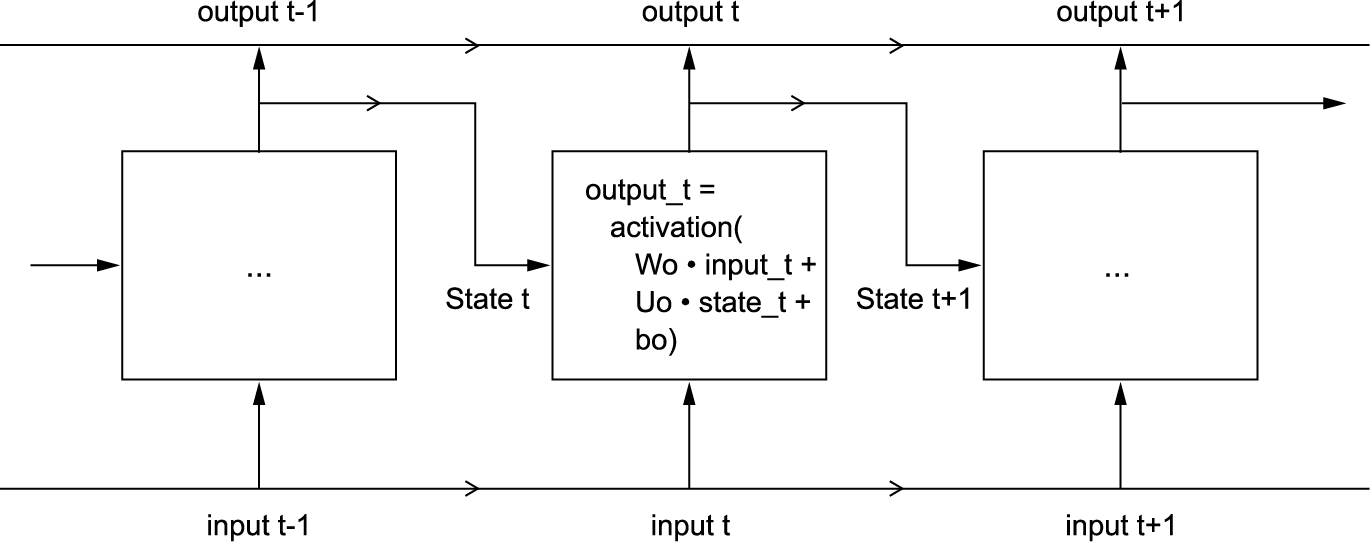

**Agreguemos** a esta imagen un **flujo de datos adicional que transporta información a través de los timesteps**. Llamamos a sus valores en diferentes timesteps ``c_t``, **donde C significa acarreo** (carry). Esta información tendrá el siguiente impacto en la celda: **se combinará con la conexión de entrada y la conexión recurrente** (**a través de una transformación densa**: **un producto escalar con una matriz de peso seguido de una suma de bias (umbrales) y la aplicación de una función de activación**), y **afectará al estado que se envía al siguiente timestep** (a través de una función de activación y una operación de multiplicación). **Conceptualmente, el flujo de datos de acarreo es una forma de modular la siguiente salida y el siguiente estado**. Sencillo hasta ahora. Lo vemos en el siguiente diagrama:

**Pasar de un SimpleRNN a un LSTM: agregar una pista de acarreo**

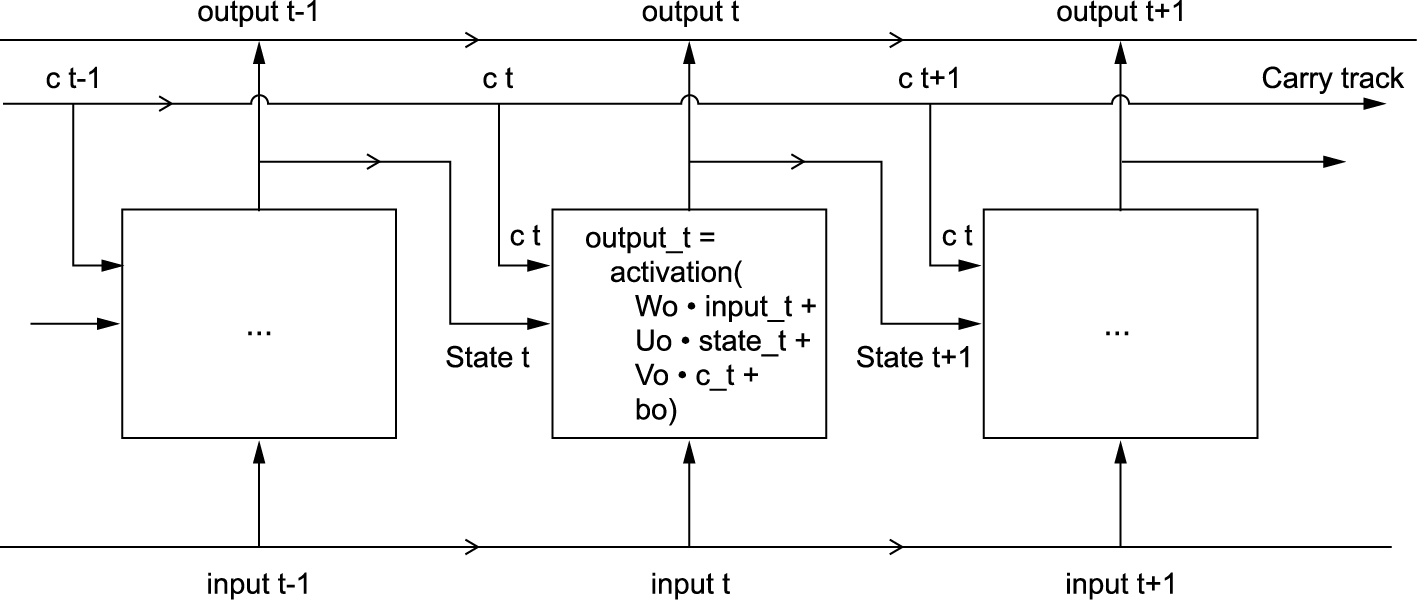

Ahora la **sutileza**: **la forma en que se calcula el siguiente valor del flujo de datos de acarreo**. **Implica tres transformaciones distintas**. Los tres **tienen la forma de una celda ``SimpleRNN``**:

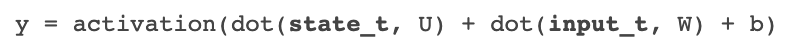

Pero **las tres transformaciones tienen sus propias matrices de peso**, que indexaremos con las letras ``i``, ``f`` y ``k``.

**Detalles de pseudocódigo de la arquitectura LSTM** (1/2)

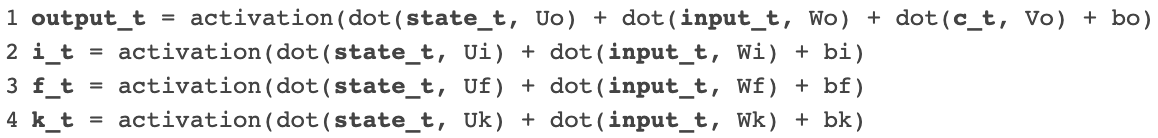

Obtenemos el nuevo estado de acarreo (el siguiente ``c_t``) combinando ``i_t``, ``f_t`` y ``k_t``.

**Detalles de pseudocódigo de la arquitectura LSTM** (2/2)

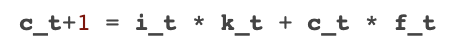

Agregamos esto como se muestra en la figura siguiente, y eso es todo. No tan complicado, simplemente un poco complejo.

**Anatomía de un LSTM**

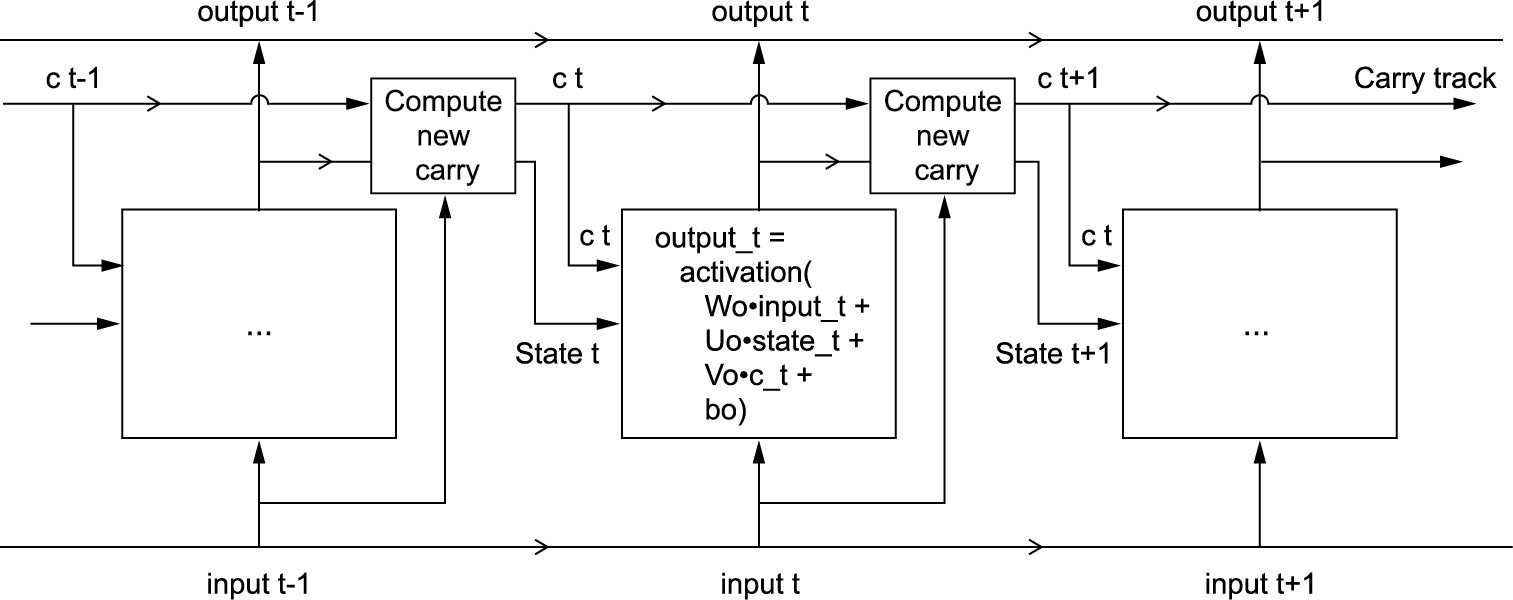

Si nos ponemos filosóficos, podemos interpretar lo que se supone que hacen cada una de estas operaciones. Por ejemplo, podemos decir que **multiplicar ``c_t`` y ``f_t`` es una forma de olvidar deliberadamente información irrelevante en el flujo de datos de acarreo**. Mientras tanto, **``i_t`` y ``k_t`` brindan información sobre el presente, actualizando la pista de acarreo con nueva información**. Pero al final, **estas interpretaciones no significan mucho**, porque **lo que realmente hacen** estas operaciones **está determinado por los contenidos de los pesos que las parametrizan**; y **los pesos se aprenden de una forma extremo a extremo, comenzando de nuevo con cada ronda de entrenamiento, lo que hace imposible acreditar tal o cual operación con un propósito específico**. La especificación de una celda RNN (como se acaba de describir) determina nuestro espacio de hipótesis (grados de libertad), el espacio en el que buscaremos una buena configuración de modelo durante el entrenamiento, pero no determina lo que hace la celda; eso depende de los pesos de las celdas. **La misma celda con diferentes pesos puede estar haciendo cosas muy diferentes**. Entonces, **la combinación de operaciones que componen una celda RNN se interpreta mejor como un conjunto de restricciones en nuestra búsqueda**, **no como un diseño en un sentido de ingeniería**. 

Podría decirse que es mejor dejar la elección de tales restricciones (la cuestión de cómo implementar las células RNN) a los algoritmos de optimización (como los algoritmos genéticos o los procesos de aprendizaje por refuerzo) que a los ingenieros humanos. En el futuro, así es como construiremos nuestros modelos. **En resumen: no necesitamos comprender nada sobre la arquitectura específica de una celda LSTM; como humano, no debería ser nuestro trabajo entenderlo**. **Solo tengamos en cuenta lo que la celda LSTM está destinada a hacer**: **permitir que la información pasada se reinyecte en un momento posterior, combatiendo así el problema del desvanecimiento del gradiente (vanishing-gradient problem.)**.

## Uso avanzado de redes neuronales recurrentes

Hasta ahora hemos aprendido:

* Qué son las **RNN y cómo funcionan** 
* Qué es **LSTM** **y por qué funciona mejor en secuencias largas que una RNN naive** 
* **Cómo usar capas Keras RNN** para procesar datos secuenciales

A continuación, **revisaremos una serie de características más avanzadas de RNN**, que pueden ayudarnos a aprovechar al máximo nuestros modelos de secuencia de aprendizaje profundo. 

Veremos: 

* **Dropout recurrente**: esta es una variante de dropout, que se usa para combatir el sobreajuste en capas recurrentes. 
* **Apilamiento de capas recurrentes**: esto aumenta el poder de representación del modelo (a costa de mayores cargas computacionales)
* **Capas recurrentes bidireccionales**: presentan la misma información a una red recurrente de diferentes maneras, lo que aumenta la precisión y mitiga los problemas de olvido. 

Usaremos estas técnicas para refinar nuestro RNN de pronóstico de temperatura.

### Usando dropout recurrente para combatir el sobreentrenamiento

Volvamos al modelo basado en LSTM que usamos anteriormente: nuestro primer modelo capaz de superar la línea de base del sentido común. Si observamos las curvas de entrenamiento y validación:

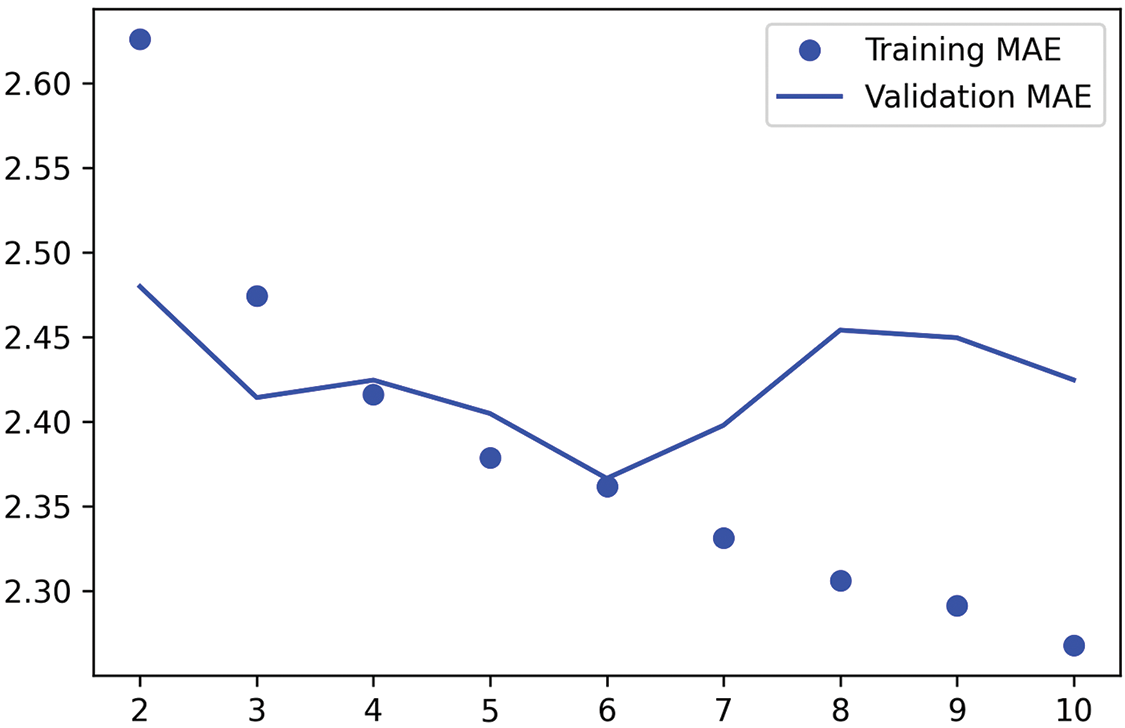

Es evidente que el modelo se sobreajusta rápidamente, a pesar de tener muy pocas unidades: las pérdidas de entrenamiento y validación comienzan a divergir considerablemente después de algunas épocas (la sexta). Ya estamos familiarizados con una técnica clásica para luchar contra este fenómeno: el **dropout**, que **pone a cero aleatoriamente las unidades de entrada de una capa para romper las correlaciones casuales en los datos de entrenamiento** a los que está expuesta la capa. Pero **cómo aplicar correctamente el dropout en redes recurrentes no es una pregunta trivial**. Hace tiempo que se sabe que **aplicar el dropout antes de una capa recurrente dificulta el aprendizaje en lugar de ayudar con la regularización**. En 2016, Yarin Gal, como parte de su tesis doctoral sobre el aprendizaje profundo bayesiano [Véase Yarin Gal, “Uncertainty in Deep Learning”, tesis doctoral (2016)](http://mlg.eng.cam.ac.uk/yarin/blog_2248.html), determinó la forma correcta de usar dropout con una red recurrente: se debe **aplicar la misma máscara de droput (el mismo patrón de unidades descartadas) en cada timestep**, en lugar de de usar una máscara de dropout que varía aleatoriamente de un paso de tiempo (timestep) a otro. **Además**, **para regularizar las representaciones formadas por las puertas recurrentes de capas** como **``GRU``** y **``LSTM``**, se debe **aplicar una máscara de dropout temporalmente constante a las activaciones recurrentes internas de la capa** (una **máscara de dropout recurrente**). El **uso de la misma máscara de dropout en cada timestep permite que la red propague correctamente su error de aprendizaje a lo largo del tiempo**; una máscara de dropout temporalmente aleatoria interrumpiría esta señal de error y sería perjudicial para el proceso de aprendizaje. 

Yarin Gal hizo su investigación usando Keras y ayudó a construir este mecanismo directamente en las capas recurrentes de Keras. **Cada capa recurrente en Keras tiene dos argumentos relacionados con el dropout**: **``dropout``**, **un número coma flotante que especifica la tasa de droput para las unidades de entrada de la capa**, y **``recurrent_dropout``**, **que especifica la tasa de droput de las unidades recurrentes**. Agreguemos dropout recurrente a la capa ``LSTM`` de nuestro primer ejemplo de LSTM y veamos cómo esto afecta el sobreajuste. 

**Gracias al dropout**, **no tendremos que depender tanto del tamaño de la red para la regularización**, por lo que **usaremos una capa LSTM con el doble de unidades**, lo que, con suerte, debería ser más expresivo (sin dropout, esta red habría comenzado a sobreajustar de inmediato, probadlo). Debido a que las **redes que se regularizan con dropout** siempre **tardan mucho más en converger** por completo, **entrenaremos el modelo con cinco veces más épocas**.

**Entrenando y evaluando una LSTM (Long Short Term Memory) regularizada con dropout**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
# Para regularizar la capa Dense, también agregamos 
# una capa Dropout después del LSTM.
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 242s 293ms/step - loss: 26.4558 - mae: 3.7974 - val_loss: 9.6320 - val_mae: 2.4107
Epoch 2/50
819/819 [==============================] - 240s 293ms/step - loss: 14.7429 - mae: 2.9840 - val_loss: 9.4329 - val_mae: 2.3783
Epoch 3/50
819/819 [==============================] - 239s 292ms/step - loss: 13.9014 - mae: 2.8939 - val_loss: 9.5155 - val_mae: 2.3875
Epoch 4/50
819/819 [==============================] - 240s 293ms/step - loss: 13.2520 - mae: 2.8229 - val_loss: 9.5843 - val_mae: 2.3873
Epoch 5/50
819/819 [==============================] - 239s 292ms/step - loss: 12.9076 - mae: 2.7842 - val_loss: 9.7909 - val_mae: 2.4146
Epoch 6/50
819/819 [==============================] - 240s 293ms/step - loss: 12.4573 - mae: 2.7384 - val_loss: 9.8858 - val_mae: 2.4324
Epoch 7/50
819/819 [==============================] - 239s 292ms/step - loss: 12.1840 - mae: 2.7089 - val_loss: 9.7403 - val_mae: 2.4159
Epoch 8/50
819/819 [=====================

El siguiente gráfico nos muestra los resultados. **¡Éxito**! Ya no estamos sobreajustando durante las primeras 20 épocas. Logramos un MAE de validación tan bajo como 2,27 grados (7% de mejora con respecto a la línea de base sin aprendizaje) y un MAE de prueba de 2,45 grados (6,5% de mejora con respecto a la línea de base). No está mal!

**Pérdida de entrenamiento y validación en la tarea de pronóstico de temperatura de Jena con un LSTM regularizado por dropout**

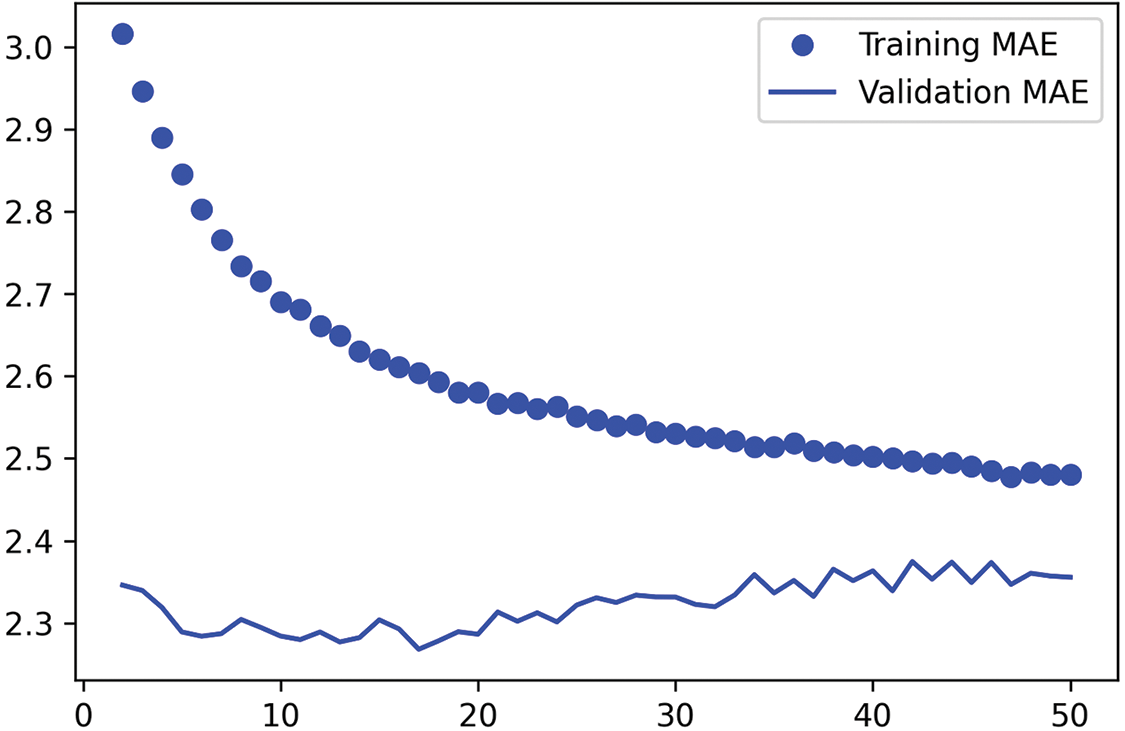

**RENDIMIENTO EN TIEMPO DE EJECUCIÓN DE RNN** 

Los modelos recurrentes con muy pocos parámetros, como los de este tema, **tienden a ser significativamente más rápidos en una CPU multinúcleo que en una GPU**, porque **solo involucran pequeñas multiplicaciones de matrices**, y la **cadena de multiplicaciones no se paraleliza bien** debido a la **presencia de un bucle ``for``**. Pero **los RNN más grandes pueden beneficiarse enormemente de un mejor tiempo de ejecución en GPU**. 

Al usar una capa Keras ``LSTM`` o ``GRU`` en GPU con sus argumentos con valores predeterminados, nuestra capa aprovechará un [kernel cuDNN](https://developer.nvidia.com/cudnn), una implementación altamente optimizada y de bajo nivel proporcionada por NVIDIA, para ejecutar el algoritmo subyacente. Como de costumbre, **los núcleos cuDNN son una bendición a medias: son rápidos, pero inflexibles**. **Si intentamos hacer algo que no sea compatible con el núcleo predeterminado, sufriremos una desaceleración dramática, lo que más o menos nos obliga a apegarnos a lo que sucede con NVIDIA (vendor locking)**. Por ejemplo, el dropout recurrente no está soportado por los kernels LSTM y GRU de cuDNN, por lo que agregarlo a nuestras capas obliga al runtime a recurrir a la implementación normal de TensorFlow, que generalmente es de dos a cinco veces más lenta en GPU (aunque el costo es el mismo). 

**Como una forma de acelerar nuestra capa RNN cuando no podemos usar cuDNN es probar** **unrolling**. **Unrolling** o desenrollado de un bucle ``for`` **consiste** en **eliminar el bucle y simplemente insertar su contenido N veces**. En el caso del bucle ``for`` de un RNN, el **unrolling** puede ayudar a TensorFlow a optimizar el gráfico de cálculo subyacente. **Sin embargo, también aumentará considerablemente el consumo de memoria de su RNN**; Esto **solo es viable para secuencias relativamente pequeñas (alrededor de 100 pasos o menos)**. Además, hay que tener en cuenta que **solo podemos hacer esto si el modelo conoce de antemano la cantidad de timesteps en los datos** (**es decir, si pasa una ``shape`` sin ninguna entrada ``None`` a su ``Input()`` inicial**). Funciona así:

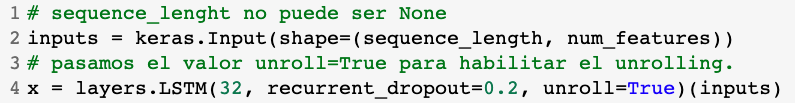

In [23]:
# sequence_lenght no puede ser None
inputs = keras.Input(shape=(sequence_length, num_features))
# pasamos el valor unroll=True para habilitar el unrolling.
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Apilando capas recurrentes

Debido a que **ya no hay sobreajuste** pero parece que **hemos topado con un cuello de botella en el rendimiento**, debemos **considerar aumentar la capacidad** y el poder expresivo **de la red**. Recordemos la descripción del flujo de trabajo de un proyecto de aprendizaje automático universal: generalmente es una buena idea **aumentar la capacidad de nuestro modelo hasta que el sobreajuste se convierta en el principal obstáculo** (**suponiendo que ya esté tomando medidas básicas para mitigar el sobreajuste, como por ejemplo, usando dropout**). Siempre que no se sobreajuste demasiado, es probable que tengamos poca capacidad. 

El **aumento de la capacidad de la red** generalmente ***se realiza aumentando la cantidad de unidades en las capas o agregando más capas***. El ***apilamiento de capas recurrentes*** es una forma clásica de construir redes recurrentes más poderosas: por ejemplo, ***no hace mucho tiempo, el algoritmo de Google Translate funcionaba con una pila de siete capas LSTM grandes, eso es enorme***. 

Para **apilar capas recurrentes una encima de la otra en Keras**, **todas las capas intermedias deben devolver su secuencia completa de salidas** (un **tensor de rango 3**) **en lugar de su salida en el último timestep**. Como ya aprendimos, esto **se hace especificando ``return_sequences=True``**. 

En el siguiente ejemplo, probaremos una **pila de dos capas recurrentes regularizadas por dropout**. Para variar, **usaremos capas de unidades recurrentes cerradas (GRU - Gated Recurrent Unit) en lugar de LSTM**. **GRU es muy similar a LSTM**: puede considerarlo como **una versión optimizada y un poco más simple de la arquitectura LSTM**. Fue introducido en 2014 por Cho et al. cuando las redes recurrentes comenzaban a ganar interés nuevamente en la entonces pequeña comunidad de investigación. [Cho et al., “On the Properties of Neural Machine Translation: Encoder-Decoder Approaches” (2014)](https://arxiv.org/abs/1409.1259)

**Entrenando y evaluando un modelo GRU (Gated Recurrent Unit-Unidad Recurrente Cerrada) apilado y regularizado con dropout**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 307s 369ms/step - loss: 25.0478 - mae: 3.6945 - val_loss: 9.3687 - val_mae: 2.3638
Epoch 2/50
819/819 [==============================] - 303s 369ms/step - loss: 14.1003 - mae: 2.9067 - val_loss: 8.9660 - val_mae: 2.3247
Epoch 3/50
819/819 [==============================] - 303s 370ms/step - loss: 13.2501 - mae: 2.8186 - val_loss: 9.5810 - val_mae: 2.4073
Epoch 4/50
819/819 [==============================] - 302s 369ms/step - loss: 12.6988 - mae: 2.7612 - val_loss: 8.7782 - val_mae: 2.2998
Epoch 5/50
819/819 [==============================] - 307s 375ms/step - loss: 12.2585 - mae: 2.7130 - val_loss: 9.5100 - val_mae: 2.4049
Epoch 6/50
819/819 [==============================] - 301s 368ms/step - loss: 11.8083 - mae: 2.6674 - val_loss: 8.9143 - val_mae: 2.3340
Epoch 7/50
819/819 [==============================] - 302s 368ms/step - loss: 11.3890 - mae: 2.6213 - val_loss: 9.0099 - val_mae: 2.3461
Epoch 8/50
819/819 [=====================

La siguiente figura muestra los resultados. Logramos un MAE de prueba de 2,39 grados (una mejora del 8,8% con respecto a la línea de base). Podemos ver que **la capa agregada mejora un poco los resultados, aunque no dramáticamente**. A partir de ahora, es posible que veamos rendimientos decrecientes al aumentar la capacidad de la red.

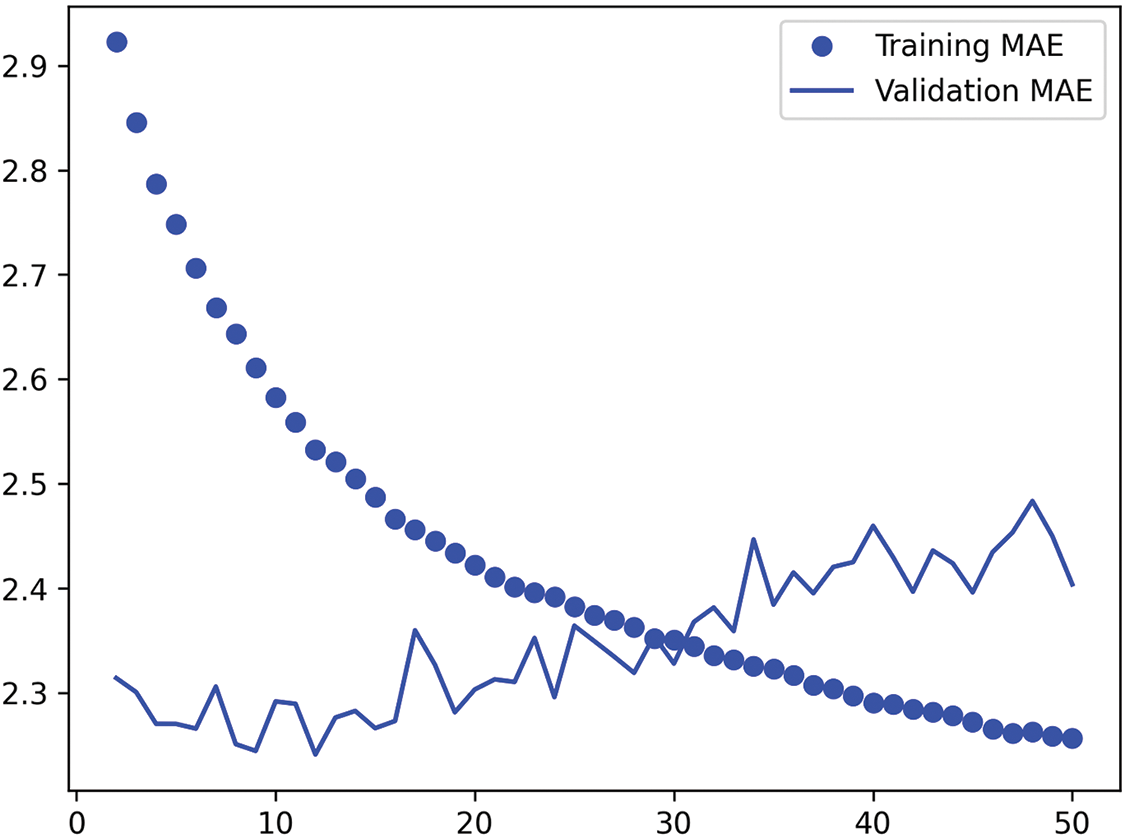

### Usando RNNs (Redes Neuronales Recurrentes) bidireccionales

La última técnica que vamos a ver es la **RNN bidireccional**. Un RNN bidireccional es una **variante común de RNN** que **puede ofrecer un mayor rendimiento** que un RNN regular **en ciertas tareas**. **Se usa con frecuencia en el procesamiento del lenguaje natural**; podría llamarlo ***la navaja suiza del aprendizaje profundo para el procesamiento del lenguaje natural***.

Los **RNN son** notablemente **dependientes del orden**: **procesan los timesteps** de sus secuencias de entrada **en orden**, y **mezclar** o **invertir** los timesteps **puede cambiar completamente las representaciones que el RNN extrae de la secuencia**. Esta es precisamente la razón por la que **tienen un buen desempeño en problemas donde el orden es significativo**, como el problema de pronóstico de temperatura. Una **RNN bidireccional explota la sensibilidad al orden de las RNN**: **utiliza dos RNN regulares, como las capas GRU y LSTM** con las que ya estamos familiarizados, **cada una de las cuales procesa la secuencia de entrada en una dirección (cronológica y anticronológicamente)** y **luego fusiona sus representaciones**. Al procesar una secuencia en ambos sentidos, **un RNN bidireccional puede detectar patrones que un RNN unidireccional puede pasar por alto**.

Hasta ahora, las capas RNN han procesado secuencias en orden cronológico (con los timesteps más antiguos primero) ¿**Podrían los RNN haber funcionado lo suficientemente bien si procesaran secuencias de entrada en orden anticronológico**, por ejemplo (con los timesteps más nuevos primero)? Intentemos esto y veamos qué sucede. Todo lo que **necesitamos hacer es escribir una variante del generador de datos donde las secuencias de entrada se revierten a lo largo de la dimensión de tiempo** (**reemplazaremos la última línea** con **``yield samples[:, ::-1, :], targets``**). Entrenando el mismo modelo basado en LSTM que usamos en el primer experimento obtenemos los siguientes resultados:

**Pérdida de entrenamiento y validación en la tarea de pronóstico de temperatura de Jena con un LSTM entrenado en secuencias inversas**

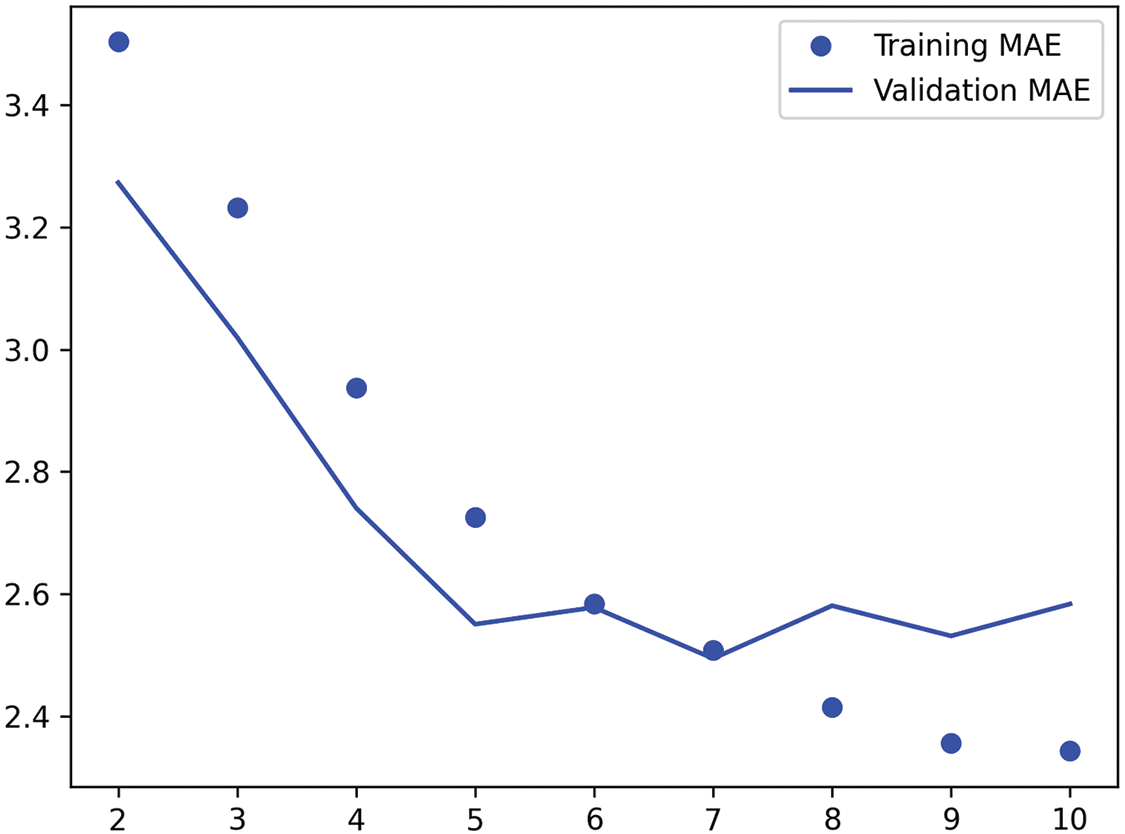

El **LSTM de orden inverso tiene un rendimiento muy inferior al de la línea base de sentido común,** lo que **indica que**, en este caso, el **procesamiento cronológico es importante para el éxito del enfoque**. Esto **tiene mucho sentido**: la **capa LSTM** subyacente normalmente **será mejor para recordar el pasado reciente que el pasado lejano** y, naturalmente, los **puntos de datos meteorológicos más recientes son más predictivos para el problema** que los puntos de datos más antiguos (eso es lo que hace que la línea de base de sentido común sea bastante buena). Por lo tanto, **la versión cronológica de la capa está destinada a superar a la versión en orden inverso**.

Sin embargo, **esto no es cierto para muchos otros problemas**, ***incluido el lenguaje natural***: ***intuitivamente, la importancia de una palabra para comprender una oración no suele depender de su posición en la oración***. En los **datos de texto**, el **procesamiento de orden inverso funciona tan bien como el procesamiento cronológico**: podemos leer el texto hacia atrás sin problemas (¡Probadlo!). Aunque el **orden de las palabras es importante** para comprender el lenguaje, **el orden que uses no es crucial**.

Es importante destacar que una **RNN entrenada en secuencias inversas aprenderá representaciones diferentes a las de una entrenada en las secuencias originales**, de la misma manera que **tendríamos diferentes modelos mentales si el tiempo fluyera hacia atrás en el mundo real**, si viviera una vida en la que murió en su primer día y naciste en tu último día. En el **aprendizaje automático, siempre vale la pena explotar las representaciones que son diferentes pero útiles, y cuanto más difieran, mejor**: ofrecen un nuevo ángulo desde el cual mirar sus datos, capturando aspectos de los datos que otros enfoques pasaron por alto, y por lo tanto, **pueden ayudar a mejorar el rendimiento en una tarea**. Esta es **la intuición detrás del (ensamblado) ensembling**, un concepto importante.....

Un **RNN bidireccional explota esta idea para mejorar el rendimiento de los RNN de orden cronológico**. Mira nuestra secuencia de entrada en ambos sentidos, **obteniendo representaciones potencialmente más ricas** y **capturando patrones que pueden haber pasado por alto solo con la versión de orden cronológico**.

**Cómo funciona una capa RNN bidireccional**

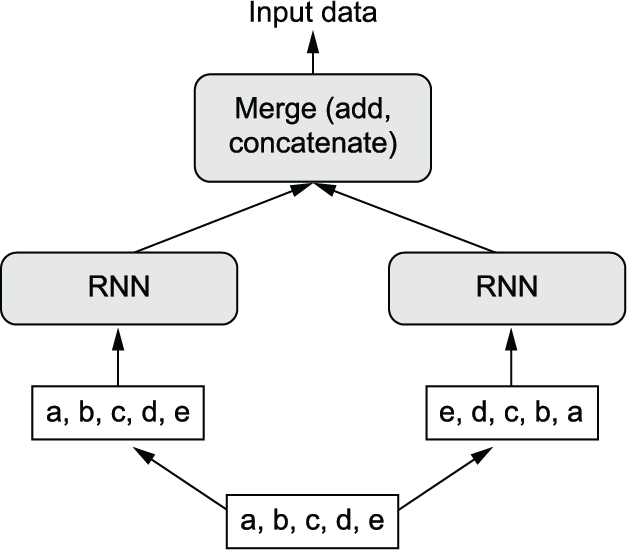

Para **instanciar un RNN bidireccional en Keras**, **utiliza la capa ``bidireccional``**, que toma como **primer argumento una instancia de capa recurrente**. **``Bidireccional`` crea una segunda instancia separada de esta capa recurrente y usa una instancia para procesar las secuencias de entrada en orden cronológico y la otra instancia para procesar las secuencias de entrada en orden inverso**. Podemos probarlo en nuestra tarea de pronóstico de temperatura.

**Entrenando y evaluando una LSTM bidireccional**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 55s 56ms/step - loss: 25.5583 - mae: 3.6362 - val_loss: 10.8723 - val_mae: 2.5608
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 9.3749 - mae: 2.3911 - val_loss: 10.1392 - val_mae: 2.4499
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 8.4955 - mae: 2.2681 - val_loss: 10.2663 - val_mae: 2.4650
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 7.9572 - mae: 2.1877 - val_loss: 10.8061 - val_mae: 2.5316
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 7.5668 - mae: 2.1332 - val_loss: 11.0000 - val_mae: 2.5440
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 7.2160 - mae: 2.0840 - val_loss: 11.3907 - val_mae: 2.6020
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 6.9025 - mae: 2.0417 - val_loss: 11.4527 - val_mae: 2.6068
Epoch 8/10
819/819 [==============================] - 

Descubriremos que **no funciona tan bien como la capa simple de ``LSTM``**. Es fácil entender por qué: **toda la capacidad predictiva debe provenir de la mitad cronológica de la red**, porque **se sabe que la mitad anticronológica tiene un rendimiento muy bajo en esta tarea** (nuevamente, **porque el pasado reciente importa mucho más que el pasado lejano, en este caso**). Al mismo tiempo, **la presencia de la mitad anticronológica duplica la capacidad de la red y hace que comience a sobreajustarse mucho antes**.

**Sin embargo**, los **RNN bidireccionales se adaptan perfectamente a los datos de texto o cualquier otro tipo de datos en los que el orden es importante**, **pero no importa el orden que utilice**. De hecho, durante un tiempo en **2016**, los **LSTM bidireccionales se consideraron lo más avanzado en muchas tareas de procesamiento de lenguaje natural** (antes del surgimiento de la **arquitectura Transformer**).

### Yendo aún más lejos

Hay muchas otras **cosas que podríamos intentar para mejorar el rendimiento en el problema de pronóstico de temperatura**:

`EJERCICIOS`
* **Ajustar la cantidad de unidades en cada capa recurrente en la configuración apilada, así como la cantidad de dropout**. Las elecciones actuales son en gran medida arbitrarias y, por lo tanto, probablemente subóptimas.
* **Ajustar la tasa de aprendizaje utilizada por el optimizador ``RMSprop``** o **probad con un optimizador diferente**.
* Intentar **utilizar una pila de capas ``Dense`` como regresor encima de la capa recurrente, en lugar de una única capa ``Dense``**.
* **Mejorar la entrada al modelo**: **intentar usar secuencias más largas o más cortas o una tasa de muestreo diferente, o comenzar a hacer ingeniería de características**.

Como siempre, el **aprendizaje profundo es más un arte que una ciencia**. Podemos proporcionar **pautas que sugieran qué es probable que funcione o no en un problema determinado**, pero, en última instancia, **cada conjunto de datos es único**; **tendréis que evaluar diferentes estrategias empíricamente**. **Actualmente no existe una teoría que os diga de antemano con precisión lo que debéis hacer para resolver un problema de manera óptima**. **Debéis iterar en una metodología ensayo-error**

La **experiencia dice** que, **mejorar la línea de base sin aprendizaje en aproximadamente un 10% es probablemente lo mejor que puede hacer con este conjunto de datos**. Esto parece que no es tan bueno, pero **estos resultados tienen sentido**: mientras que ***el clima del futuro cercano es altamente predecible si tiene acceso a datos de una amplia red de diferentes ubicaciones***, ***no es muy predecible si solo tiene mediciones de una sola ubicación***. ***La evolución del clima en el lugar donde nos encontramos depende de los patrones climáticos actuales en los lugares circundantes***.

**MERCADOS Y APRENDIZAJE AUTOMÁTICO** 

Algunos de vosotros querréis tomar las técnicas que hemos visto aquí y probarlas en el problema de **pronosticar el precio futuro de valores en el mercado de acciones** (o tipos de cambio de divisas, etc.). Sin embargo, **los mercados tienen características estadísticas muy diferentes a los fenómenos naturales como los patrones climáticos**. Cuando se trata de mercados, **el rendimiento pasado no es un buen predictor de los rendimientos futuros**: **mirar por el espejo retrovisor es una mala forma de conducir**. El **aprendizaje automático, por otro lado, es aplicable a conjuntos de datos donde el pasado es un buen predictor del futuro, como el clima, el consumo de electricidad o el tráfico peatonal en una tienda**. 

Recordad siempre que **obtener ventaja competitiva** se produce **al aprovechar datos o conocimientos que otros participantes del mercado no tienen**. Intentar **utilizar técnicas conocidas de aprendizaje automático y datos disponibles públicamente para vencer a los mercados es un callejón sin salida**, ya que **no tendremos ninguna ventaja de información en comparación con los demás**. Es probable que pierdas tu tiempo y recursos para nada.

## Resumen

* Al **abordar un nuevo problema**, es bueno **establecer primero líneas de base de sentido común para la métrica que elijamos**. Si no tenemos una línea de base para superar, no podemos saber si estamos haciendo un progreso real. 
* **Probemos modelos simples antes que costosos**, para **asegurarse de que el gasto adicional esté justificado**. A veces, un modelo simple resultará ser su mejor opción. 
* Cuando tengamos **datos donde el orden es importante**, y en particular para **datos de series temporales**, las **redes recurrentes se adaptan perfectamente y superan fácilmente a los modelos que primero aplanan los datos temporales**. **Las dos capas RNN esenciales disponibles en Keras son la capa ``LSTM`` y la capa ``GRU``**
* Para **usar dropout con redes recurrentes**, debe **usar una máscara de dropout constante en el tiempo y una máscara de dropout recurrente**. Estos **están integrados en las capas recurrentes de Keras**, por lo que todo lo que tiene que hacer es **usar los argumentos ``recurrent_dropout``** de las capas recurrentes.
* Los **RNN apilados brindan más poder de representación que una sola capa de RNN**. También son **mucho más caros** y, por lo tanto, no siempre valen la pena. Aunque ofrecen **beneficios claros en problemas complejos** (como la **traducción automática**), es posible que **no siempre sean la mejor opción para problemas más pequeños y simples**.